<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/BlackScholes_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black-Scholes Partial Differential Equation (PDE)
The value of an option $V(S, t)$ satisfies the Black-Scholes PDE:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

### Initial and Boundary Conditions of the Black-Scholes PDE

The initial and boundary conditions for the Black-Scholes PDE depend on the type of derivative being priced, such as European call or put options. These conditions are necessary for solving the PDE and obtaining specific option prices. We will consider a Call option.

- $\textbf{Initial Condition}$ (at $t = T$):
    - $\text{Call: } V(S, T) = \max(S - K, 0)$ \\
- $\textbf{Boundary Conditions:}$
  - $V(0, t) = 0$ \\
  - $V(S, t) \to S - K e^{-r(T-t)} \quad \text{as } S \to \infty$

These conditions, combined with the Black-Scholes PDE, provide a complete specification for determining the price of the option.


## Implementation

In [34]:
import torch
import torch.nn.functional as F

## Analytic formula

In [45]:
import torch

def black_scholes(S, K, T, t, r, sigma, option_type="call"):
    """
    Compute the Black-Scholes option price.

    Args:
        S (torch.Tensor): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity.
        t (float): Current time (typically 0).
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the stock price.
        option_type (str): "call" or "put".

    Returns:
        torch.Tensor: Option price.
    """
    # Ensure inputs are PyTorch tensors and have the correct dtype
    S = S.type(torch.float32) # Changed to type casting

    # Time to maturity
    tau = T - t

    # Avoid division by zero for tau = 0
    epsilon = 1e-8

    # Convert r and tau to tensors
    r = torch.tensor(r, dtype=torch.float32)
    tau = torch.tensor(tau, dtype=torch.float32)

    # Compute d1 and d2
    # Use tau and epsilon directly for torch.sqrt, no need to create new tensors
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * torch.sqrt(tau + epsilon))
    d2 = d1 - sigma * torch.sqrt(tau + epsilon)

    # Compute N(d1) and N(d2) using the cumulative distribution function
    N_d1 = 0.5 * (1.0 + torch.erf(d1 / torch.sqrt(torch.tensor(2.0))))
    N_d2 = 0.5 * (1.0 + torch.erf(d2 / torch.sqrt(torch.tensor(2.0))))

    # Compute the call or put price
    if option_type == "call":
        option_price = S * N_d1 - K * torch.exp(-r * tau) * N_d2
    elif option_type == "put":
        option_price = K * torch.exp(-r * tau) * (1.0 - N_d2) - S * (1.0 - N_d1)
    else:
        raise ValueError("Invalid option_type. Must be 'call' or 'put'.")

    return option_price

In [46]:
# Example Usage
S = torch.tensor([100.0], dtype=torch.float32)  # Stock price
K = 100.0  # Strike price
T = 1.0    # Time to maturity
t = 0.0    # Current time
r = 0.05   # Risk-free rate
sigma = 0.2  # Volatility

# Compute call and put prices
call_price = black_scholes(S, K, T, t, r, sigma, option_type="call")
put_price = black_scholes(S, K, T, t, r, sigma, option_type="put")

print(f"Call Price: {call_price.item():.4f}")
print(f"Put Price: {put_price.item():.4f}")

Call Price: 10.4506
Put Price: 5.5735


In [19]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [20]:
def bs_pde_residual(model, s, t, r, sigma):
    """
    Compute the PDE residual for Black-Scholes equation:
    """
    s.requires_grad = True
    t.requires_grad = True
    V = model(torch.cat((s, t), dim=1))

    # Gradients w.r.t. x and t
    V_s = torch.autograd.grad(V, s, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # Second-order derivative w.r.t. x
    V_ss = torch.autograd.grad(V_s, s, grad_outputs=torch.ones_like(V_s), create_graph=True)[0]

    # PDE residual
    residual = V_t + 0.5*sigma**2*s**2*V_ss + r*s*V_s -r*V
    return residual

# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network for heat equation."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),  # Inputs: (x, t)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: u(x, t)
        )

    def forward(self, x):
        return self.hidden_layers(x)

# Step 3: Define the loss function
def compute_loss(model, s_interior, t_interior, s_boundary, t_boundary, s_initial, t_initial, V_initial,
                 r, sigma):
    """Compute the combined loss for the PDE residual, boundary, and initial conditions."""
    # PDE residual loss
    residual = bs_pde_residual(model, s_interior, t_interior, r, sigma)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss: u(0, t) = 0 and u(1, t) = 0
    u_boundary_left = model(torch.cat((s_boundary[0], t_boundary), dim=1))
    u_boundary_right = model(torch.cat((s_boundary[1], t_boundary), dim=1))
    bc_loss = torch.mean(u_boundary_left**2) + torch.mean(u_boundary_right**2)

    # Initial condition loss: u(x, 0) = sin(πx)
    s_initial_pred = model(torch.cat((s_initial, t_initial), dim=1))
    ic_loss = torch.mean((s_initial_pred - s_initial)**2)

    return pde_loss + bc_loss + ic_loss

# Step 4: Training the model
def train_pinn(model, s_interior, t_interior, s_boundary, t_boundary, s_initial, t_initial, V_initial,
               r, sigma, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, s_interior, t_interior, s_boundary, t_boundary, s_initial, t_initial, V_initial, r, sigma)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs, tolerance_grad=1e-7, tolerance_change=1e-9)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, s_interior, t_interior, s_boundary, t_boundary, s_initial, t_initial, V_initial, r, sigma)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [21]:
# Step 5: Generate training data
# Domain: s ∈ [strike//2, 2*strike], t ∈ [0, 1] (1 year)
T = 1.0 # one year
strike = 100.0
r = 0.05
sigma = 0.2
s = torch.linspace(strike//2, 2*strike, 100).view(-1, 1)
t = torch.linspace(0, T, 100).view(-1, 1)

# Create mesh grid for interior points
s_grid, t_grid = torch.meshgrid(s.squeeze(), t.squeeze(), indexing='ij')
s_interior = s_grid.flatten().view(-1, 1)
t_interior = t_grid.flatten().view(-1, 1)

# Boundary points
s_goes_infinity = 2*strike - strike*torch.exp(-r*(T-t))
s_boundary = [torch.full_like(t, 0), s_goes_infinity]
t_boundary = t

# Initial points
s_initial = s
t_initial = torch.zeros_like(t)
V_initial = torch.max(s - strike, torch.tensor(0.0))

In [22]:
# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, s_interior, t_interior, s_boundary, t_boundary, s_initial, t_initial, V_initial,
           r, sigma,
           adam_epochs=1000, lbfgs_epochs=500)

Adam Epoch 0, Loss: 17606.177734375
Adam Epoch 100, Loss: 15549.1201171875
Adam Epoch 200, Loss: 14464.1181640625
Adam Epoch 300, Loss: 13574.4248046875
Adam Epoch 400, Loss: 12828.4541015625
Adam Epoch 500, Loss: 12203.1123046875
Adam Epoch 600, Loss: 11682.1259765625
Adam Epoch 700, Loss: 11252.009765625
Adam Epoch 800, Loss: 10900.791015625
Adam Epoch 900, Loss: 10617.591796875
Starting LBFGS optimization...


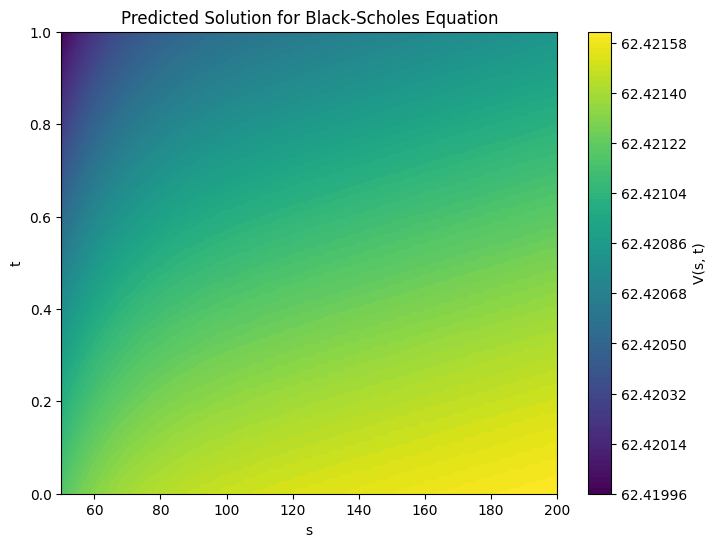

In [23]:
# Step 7: Visualize the results
# Create a grid for prediction
s_pred = torch.linspace(strike//2, 2*strike, 100).view(-1, 1)
t_pred = torch.linspace(0, T, 100).view(-1, 1)

s_grid_pred, t_grid_pred = torch.meshgrid(s_pred.squeeze(), t_pred.squeeze(), indexing='ij')
s_flat = s_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Predict using the trained model
V_pred = model(torch.cat((s_flat, t_flat), dim=1)).detach().numpy()
V_pred = V_pred.reshape(100, 100)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.contourf(s_grid_pred.numpy(), t_grid_pred.numpy(), V_pred, levels=100, cmap='viridis')
plt.colorbar(label='V(s, t)')
plt.xlabel('s')
plt.ylabel('t')
plt.title('Predicted Solution for Black-Scholes Equation')
plt.show()


In [38]:
V_pred

array([[62.42117 , 62.42116 , 62.42115 , ..., 62.419994, 62.419975,
        62.41996 ],
       [62.421196, 62.42119 , 62.421185, ..., 62.420036, 62.420025,
        62.42001 ],
       [62.421227, 62.42122 , 62.421207, ..., 62.420082, 62.42007 ,
        62.420055],
       ...,
       [62.42162 , 62.42161 , 62.42161 , ..., 62.420834, 62.420822,
        62.42081 ],
       [62.42162 , 62.421616, 62.42161 , ..., 62.420837, 62.420822,
        62.420815],
       [62.42162 , 62.42162 , 62.42161 , ..., 62.42084 , 62.42083 ,
        62.420822]], dtype=float32)

In [33]:
# Example Usage
S = torch.tensor([100.0], dtype=torch.float32)  # Stock price
K = 100.0  # Strike price
T = 1.0    # Time to maturity
t = 0.0    # Current time
r = 0.05   # Risk-free rate
sigma = 0.2  # Volatility

# Compute call and put prices
call_price = black_scholes(S, K, T, t, r, sigma, option_type="call")
put_price = black_scholes(S, K, T, t, r, sigma, option_type="put")

print(f"Call Price: {call_price.item():.4f}")
print(f"Put Price: {put_price.item():.4f}")

Call Price: 10.4506
Put Price: 5.5735


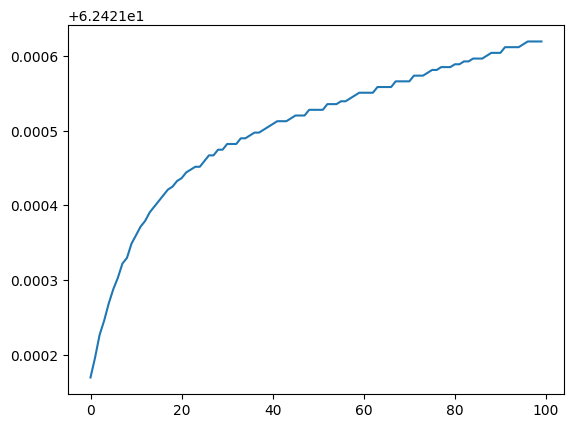

In [39]:
plt.plot(V_pred[:,0])

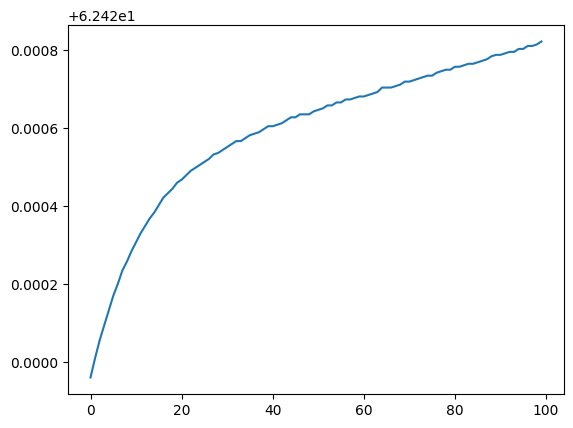

In [40]:
plt.plot(V_pred[:,-1])

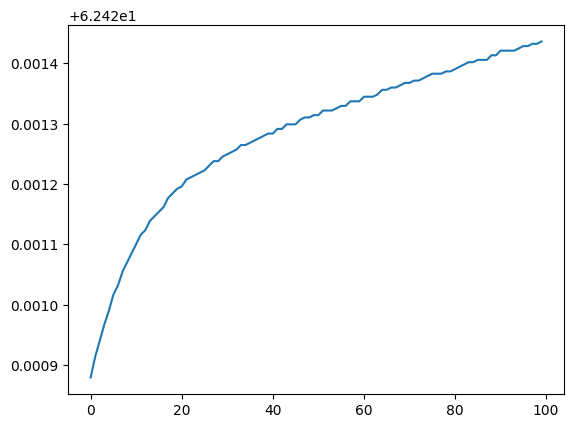

In [41]:
plt.plot(V_pred[:,30])

In [ ]:
# u from exact function
V_exact = V_close_(x_flat, t_flat)
V_exact = V_pred.reshape(100, 100)

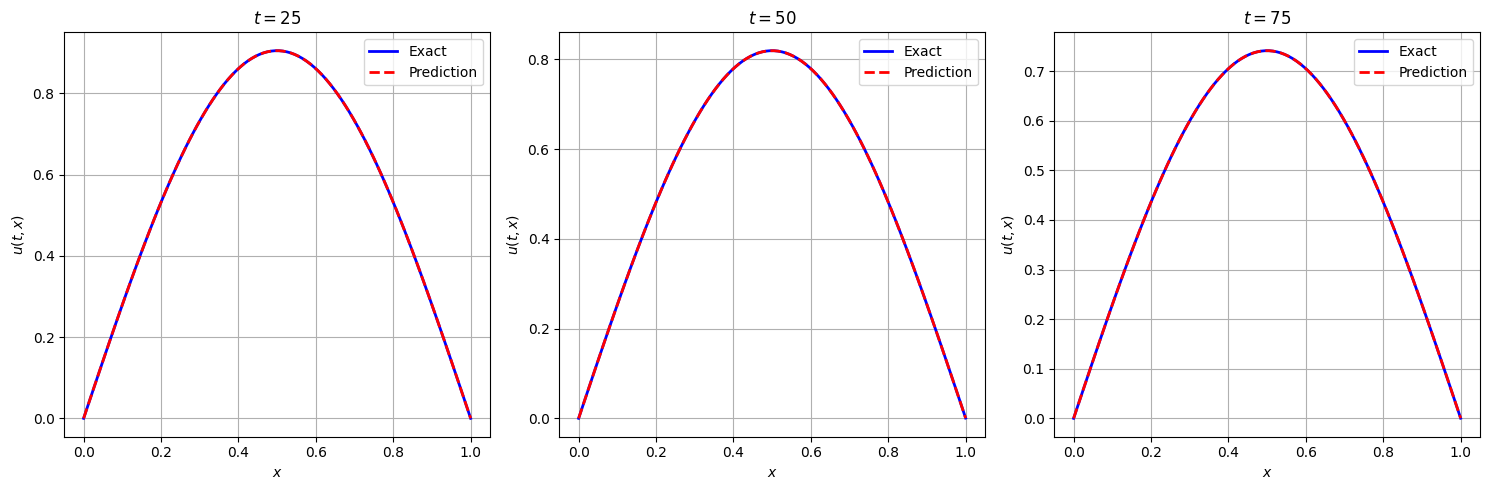

In [ ]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 50, 75]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    t_slice_tensor = torch.full_like(x_pred, t_slice)
    u_pred_slice = u_pred[:, t_slice]

    # Compute exact solution
    u_exact_slice = u_exact[:,t_slice]

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(x.numpy(), u_exact_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(x.numpy(), u_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$x$")
    plt.ylabel("$u(t, x)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
